In [14]:
import jsonlines
import numpy as np
import tensorflow as tf
import nltk
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [15]:
tf.reset_default_graph()

In [16]:
sess = tf.Session()

In [17]:
batch_size = 50
max_features = 200

Read the train data from file and save into question and label list

In [18]:
questions = []
labels = []
with jsonlines.open("web_com.jsonl", "r") as reader:
    for line in reader:
        questions.append(line["question"])
        labels.append(line["label"])

clean the question and and convert label to binary number (need to remove any NoneType in question later）

In [19]:
labels = [1 if x == "website" else 0 for x in labels]
# convert all question to lowercase
questions = [x.lower() for x in questions]
# delete any punctuation
questions = [''.join(c for c in x if c not in string.punctuation) for x in questions]
# trim extra whitespace
questions = [x.strip() for x in questions]

Use word tokenizer from nltk and extract the feature with TF-IDF vector with SciKit-Learn

In [26]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords.words('english'), max_features=max_features)
sparse_matrix_question = tfidf.fit_transform(questions)

Split the data into train/test

In [27]:
train_indices = np.random.choice(sparse_matrix_question.shape[0], round(0.8*sparse_matrix_question.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_matrix_question.shape[0])) - set(train_indices)))
texts_train = sparse_matrix_question[train_indices]
texts_test = sparse_matrix_question[test_indices]
target_train = np.array([x for ix, x in enumerate(labels) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(labels) if ix in test_indices])

In [9]:
A = tf.Variable(tf.random_normal(shape=[max_features, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

model_output = tf.add(tf.matmul(x_data, A), b)

In [10]:
# declare the loss function (cross entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# result 
result = tf.sigmoid(model_output)

In [11]:
# declare optimizer
optimizer = tf.train.GradientDescentOptimizer(0.0025)
train_step = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [12]:
saver = tf.train.Saver(max_to_keep=4)

In [13]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i+1) % 100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    
    if (i+1) % 1000 == 0:
        # save the model every 1000 step
        saver.save(sess, "./model", global_step=i+1)
        
    if (i+1) % 500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 0.99 (0.97). Train Acc (Test Acc): 0.38 (0.41)
Generation # 1000. Train Loss (Test Loss): 0.94 (0.89). Train Acc (Test Acc): 0.40 (0.44)
Generation # 1500. Train Loss (Test Loss): 0.80 (0.84). Train Acc (Test Acc): 0.50 (0.49)
Generation # 2000. Train Loss (Test Loss): 0.90 (0.82). Train Acc (Test Acc): 0.36 (0.52)
Generation # 2500. Train Loss (Test Loss): 0.74 (0.82). Train Acc (Test Acc): 0.44 (0.49)
Generation # 3000. Train Loss (Test Loss): 0.62 (0.81). Train Acc (Test Acc): 0.68 (0.47)
Generation # 3500. Train Loss (Test Loss): 0.80 (0.81). Train Acc (Test Acc): 0.48 (0.51)
Generation # 4000. Train Loss (Test Loss): 0.62 (0.82). Train Acc (Test Acc): 0.66 (0.52)
Generation # 4500. Train Loss (Test Loss): 0.62 (0.82). Train Acc (Test Acc): 0.70 (0.52)
Generation # 5000. Train Loss (Test Loss): 0.64 (0.82). Train Acc (Test Acc): 0.62 (0.54)
Generation # 5500. Train Loss (Test Loss): 0.76 (0.82). Train Acc (Test Acc): 0.52 (0.53)
Generation 

In [14]:
te = "where can i purchase the xpax"
te = te.lower().strip().replace("?", "")
te = tfidf.transform([te])
for i in te.indices:
    for key, item in tfidf.vocabulary_.items():
        if item == i:
            print(key)
result = sess.run(result, feed_dict={x_data: te.todense()})[0][0]
print("0: community\n1: website")
print(result)

purchase
0: community
1: website
0.77556527


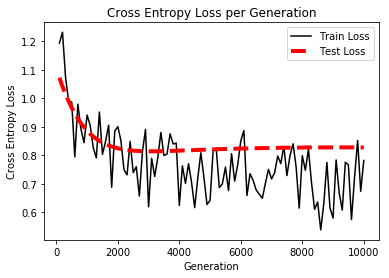

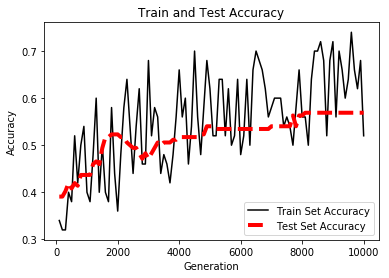

In [15]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()